# Bungee jumper

As part of this project, I prepared a program to calculate the motion parameters of a bungee jumper jumping from a basket lift located at a height of $h$ above ground level. The origin of the two-dimensional Cartesian coordinate system, $(0,0)$ was placed at the point where the rope is attached to the basket of the elevator (see figure below). The jumper was simplified to a point of mass $m$, and its initial position is described by the coordinates $(x_s, y_s)$.

During the jumper's flight, we assume that the jumper is affected by the force of gravity, $vec{G}$, the elastic force of the rope caused by its elongation, $vec{S}$, and the force of resistance to motion, $vec{O}$. However, we will omit the effect of wind and assume a rigid lift.


<div> <img src="dzwig.png" alt="Drawing" style="width: 400px;"/></div> 

Since I am working with matrices and vectors in this project, I am importing the `numpy` library. In addition, I import the `matplotlib.pyplot` library to visualize the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

At the beginning, it defines some constants. I assume that the height of the basket above the terrain is $h = 30 \textrm{m}$, the mass of the jumper is $m = 80 \textrm{kg}$. The jumper's initial position is $1 \textrm{m}$ to the left of the rope attachment point, i.e. $x_s = -1$ and $y_s = 0$.

In [2]:
h = 30      # wysokość dźwigu [m]
m = 80      # masa skoczka [kg]
xs, ys = -1, 0     # współrzędne x i y początkowej pozycji skoczka

To calculate the value of the gravitational force, $\vec{G}$, I define the gravitational acceleration $g = 9.81 \ \textrm{m}/\textrm{s}^2$. The force $\vec{G}$ is the product of the mass of the jumper and the gravitational acceleration.

In [3]:
g= 9.81     # przyspieszenie grawitacyjne [m/s^2]

We can express the elastic force of the rope, $\vec{S}$, in simplified terms as the product of the stiffness of the rope and its elongation. The action scheme of a bungee cord can be simplified to that of a spring, whose stiffness decreases with elongation. Therefore, I will use a simplified model where the stiffness of the rope will be $k_1$ for elongation less than $e_b$, and then $k_2$ for elongation greater than $e_b$, where $k_1 > k_2$.

Assume a bungee rope with an initial length of $L = 10$ \ \textrm{m}$ and parameters $k_1 = 200 \ \textrm{N}/\textrm{m}$, $k_2 = 110 \ \textrm{N}/\textrm{m}$ and $e_b = 5 \ \textrm{m}$.

In [4]:
k_1 = 200           # sztywność liny dla e < e_b [N/m]
k_2 = 110           # sztywność liny dla e > e_b [N/m]
e_b = 5             # wydłużenie przy którym zmienia się sztywność [m]
k = [k_1, k_2]
L = 10              # długość początkowa liny [m]

My simplified model also assumes that the force of resistance to motion, $\vec{O}$, is directly proportional to the square of the jumper's velocity. To determine the proportionality factor, $d$, I will need to define additional parameters of the jumper and the surrounding air. Let's assume an air density of $\rho = 1.2 \ \textrm{kg}/\textrm{m}^3$, an aerodynamic drag coefficient of $c_x = 1$ (for a skydiver falling flat), and a throw area of the jumper's body $a_c = 0.8 \textrm{m}^2$. The coefficient of resistance to motion, $d$, is then calculated as the product of the defined parameters (this coefficient has the unit of $\dfrac{\textrm{N}\cdot\textrm{s}^2}{\textrm{m}^2}$).

In [5]:
rho = 1.2       # gęstość powietrza [kg/m^3]
cx = 1.0        # współczynnik oporu aerodynamicznego
ac = 0.8        # powierzchnia rzutu ciała skoczka [m^2]
d = rho*cx*ac   # współczynnik oporu ruchu

Finally, let's set the duration of the jump simulation $t_{max} = 30  \ \textrm{s}$ and the number of time steps for which the jump simulation will be performed, $nt = 100000$.

**NOTE** The solution to this task is an approximate solution and depends directly on the number of time steps taken. For this reason, the parameter $nt$ should be large enough for the solution to be correct.

In [6]:
t_max = 30      # maksymalny czas [s]
nt = int(1e5)   # liczba kroków czasowych

## 1. Matrix initialization

To begin with, I initialize the arrays (arrays) that will be needed to perform the jump simulation. In other words, in this step we reserve space in the computer's memory so that it is capable of storing all the required numbers. Accordingly, you need to create arrays (matrices) of appropriate dimensions that will store the results related to the current time, rope length, position, speed and acceleration of the jumper, as well as the forces acting on him.


In [7]:
def init_time(t_max, nt):
    '''
    Cel:
        Funkcja tworzy wektor czasu t oraz określa przyrost czasu pomiędzy 
        kolejnymi krokami dt.
    Argumenty:
        t_max - maksymalny czas symulacji (s)
        nt - liczba kroków symulacji
    Wartości:
        t - wektor (długość nt), zawierający nt równo rozłożonych 
            punktów czasu od 0 do t_max (s)
        dt - przyrost czasu pomiędzy kolejnymi krokami (s)
    '''
    t = np.linspace(0, t_max, nt)
    
    dt = t[1]-t[0]

    return t, dt

t, dt  = init_time(t_max,nt)

In [8]:
def init_position(nt):
    '''
    Cel:
        Funkcja tworzy wektory współrzędnych x,y skoczka oraz wektory 
        informacji o aktualnych parametrach liny r, e. Dane te są na tym etapie
        wypełnione zerami i będą nadpisywane w dalszej części algorytmu.
    Argumenty:
        nt - liczba kroków symulacji
    Wartości:
        x - wektor (długość nt), zawierający współrzędną x skoczka w czasie (m)
        y - wektor (długość nt), zawierający współrzędną y skoczka w czasie (m)
        r - wektor (długość nt), zawierający długość liny w czasie (m)
        e - wektor (długość nt), zawierający wydłużenie liny w czasie (m)
    '''
    x = np.zeros(nt)
    y = np.zeros(nt)
    r = np.zeros(nt)
    e = np.zeros(nt)
    return x, y, r, e


x, y, r, e = init_position(nt)

In [9]:
def init_speed(nt):
    '''
    Cel:
        Funkcja tworzy trójkolumnową macierz prędkości skoczka V, gdzie 
        kolumna nr 0 zawiera prędkość na kierunku x,
        kolumna nr 1 zawiera prędkość na kierunku y,
        kolumna nr 2 zawiera wypadkową prędkość skoczka. Dane te są na tym 
        etapie wypełnione zerami i będą nadpisywane w dalszej części algorytmu.
    Argumenty:
        nt - liczba kroków symulacji
    Wartości:
        V - macierz (nt,3), zawierająca odpowiednie prędkości skoczka w czasie
        (m/s)   
    '''
    V = np.zeros((nt, 3))
    return V

V = init_speed(nt)

In [10]:
def init_acceleration(nt):
    '''
    Cel:
        Funkcja tworzy trójkolumnową macierz przyspieszeń skoczka A, gdzie 
        kolumna nr 0 zawiera przyspieszenie na kierunku x,
        kolumna nr 1 zawiera przyspieszenie na kierunku y,
        kolumna nr 2 zawiera wypadkowe przyspieszenie skoczka. Dane te są na 
        tym etapie wypełnione zerami i będą nadpisywane w dalszej części 
        algorytmu.
    Argumenty:
        nt - liczba kroków symulacji
    Wartości:
        A - macierz (nt,3), zawierająca odpowiednie przyspieszenia skoczka w
        czasie (m/s2)   
    '''
    A = np.zeros((nt, 3))
    return A

A = init_acceleration(nt)

In [11]:
def init_force(m, g, nt):
    '''
    Cel:
        Funkcja tworzy macierze, zawierające siły działające na skoczka, w tym 
        siłę grawitacji, siłę sprężystości liny, siły oporów ruchu oraz siłę 
        wypadkową, gdzie w każdej z sił
        kolumna nr 0 zawiera składową siły na kierunku x,
        kolumna nr 1 zawiera składową siły na kierunku y,
        kolumna nr 2 zawiera siłę wypadkową (jeżeli jest potrzebna). Dane te są 
        na tym etapie wypełnione zerami i będą nadpisywane w dalszej części. 
        Wyjątkiem jest siła grawitacji, która w pierwszej kolumnie zawiera
        zera, a w kolumnie drugiej zawiera wartość siły ciążenia, działającej
        na skoczka, zgodnie z jej zwrotem.
    Argumenty:
        m - masa skoczka (kg)
        g - przyspieszenie grawitacyjne (m/s2)
        nt - liczba kroków symulacji
    Wartości:
        G - macierz (nt,2), zawierająca odpowiednie składowe siły grawitacji w
        czasie (N)
        S - macierz (nt,3), zawierająca odpowiednie składowe siły sprężystości 
        liny w czasie (N)
        O - macierz (nt,2), zawierająca odpowiednie składowe siły oporów ruchu 
        w czasie (N)
        F - macierz (nt,3), zawierająca wypadkową sił, działających na skoczka
        w czasie (N)
    '''
    G = np.zeros((nt, 2))
    G[:, 1] = -m*g
    
    S = np.zeros((nt, 3))
    O = np.zeros((nt, 2))
    F = np.zeros((nt, 3))

    return G, S, O, F

G, S, O, F = init_force(m,g,nt)

## 2. Initial calculation step

The next step is to determine the initial position of the jumper, i.e. I determine that the $x$ and $y$ coordinates at the first time step will be $x_s$ and $y_s$, respectively. Then, based on this, I determine the initial length of the bungee cord $r_1 = \sqrt{x_s^2 + y_s^2}$$. The next step is to determine the initial forces acting on the jumper and enter them into the force matrix $r_1 = $\mathbf{F}$. Recall the convention adopted: the row number of the matrix corresponds to the next time instant, and the columns $0$, $1$, and $2$ correspond to the component in the $x$, $y$ and resultant vector directions, respectively.

At the first time step, the $x$ component of the resultant force will be $0$, which will be denoted as $\mathbf{F}_{0,x} \equiv \mathbf{F}(0,0)  = 0$. Similarly, I define the $y$ component of the resultant force in the first time step, i.e. $\mathbf{F}_{0,y} \equiv \mathbf{F}(0,1) = \mathbf{G}(0,1)$, where $\mathbf{G}$ I defined when initializing the force arrays above. Then, based on the components of the forces, I determine their resultant, i.e. $\mathbf{F}_{0,w} \equiv \mathbf{F}(0,2) = \sqrt{\mathbf{F}_{0,x}^2 + \mathbf{F}_{0,y}^2 } $. Having determined the resultant force acting on the jumper, I can calculate his acceleration according to the equation $\mathbf{A}_{0} = \mathbf{F}_{0} / m$.

In [12]:
x[0] = xs
y[0] = ys
r[0] = np.sqrt(x[0]**2 + y[0]**2)

F[0,0] = 0
F[0,1] = G[0,1]
F[0,2] = np.sqrt(F[0,0]**2 + F[0,1]**2)

A[0,:] = F[0,:]/m

## 3. Integration of the equations of motion

Using the initial motion parameters determined above, I can proceed to calculate these parameters for subsequent time steps. To do this, I will write a loop that will iterate through the steps from $2$ to $nt$ (for the first step, we determined the parameters in the previous section):

`for i in range(1,nt):`.

Then, for subsequent time steps I will determine quantities such as the speed of the jumper, his position and the parameters of the rope. To determine them, I will write appropriate functions. At this stage, let's define that step $i$ denotes the *current* step, and step $i-1$ will denote the *previous* step.

The value of the time increment $dt$ was determined at the stage of initialization of the arrays. For the assumptions we made, $dt = 0.00003 \ \textrm{s}$. This is how much time forward I will "predict" the parameters of the jumper's movement.

### 3.1 Jumper speed

I'll start with a function that calculates the *actual* speed of the jumper, based on the quantities from the *previous* step. To do this, I will use the following formulas:

$v_{i,x} = v_{i-1,x} + a_{i-1,x} \cdot dt$,

$v_{i,y} = v_{i-1,y} + a_{i-1,y} \cdot dt$,

$v_{i,w} = \sqrt{v_{i-1,x}^2 + v_{i-1,y}^2}$,

$mathbf{V}_i = [v_{i,x}, v_{i,y}, v_{i,w} ]$.

I will call the function for the $i$th time step as follows:

`V[i,:] = calculate_speed(V[i-1,0], V[i-1,1], A[i-1,0], A[i-1,1], dt)`.

In [13]:
def calculate_speed(vi_1x, vi_1y, ai_1x, ai_1y, dt):
    '''
    Cel:
        Funkcja oblicza prędkość lotu skoczka w aktualnym kroku, bazując na
        danych z kroku poprzedniego.
    Argumenty:
        vi_1x - prędkość na kierunku x w poprzednim kroku (m/s)
        vi_1y - prędkość na kierunku y w poprzednim kroku (m/s)
        ai_1x - przyspieszenie na kierunku x w poprzednim kroku (m/s2)
        ai_1y - przyspieszenie na kierunku y w poprzednim kroku (m/s2)
        dt - przyrost czasu pomiędzy krokami (s)
    Wartości:
        Vi - wektor (długość 3), zawierający odpowiednie składowe prędkości (m/s)    
    '''
    
    Vix = vi_1x + ai_1x*dt
    Viy = vi_1y + ai_1y*dt

    Vi = np.array([Vix, Viy, (Vix**2 + Viy**2)**0.5])

    return Vi

### 3.2 Jumper position

The next function will calculate the *actual* position of the jumper, based on the quantities from the *previous* step. To do this, I will use the following equations:

$ x_i = x_{i-1} + v_{i-1,x} \cdot dt + a_{i-1,x} \cdot \dfrac{dt^2}{2}$, 

$ y_i = y_{i-1} + v_{i-1,y} \cdot dt + a_{i-1,y} \cdot \dfrac{dt^2}{2}$.

I will call the function for the $i$th time step as follows:

`x[i], y[i] = calculate_jumper_position(x[i-1],y[i-1],V[i-1,0],V[i-1,1],A[i-1,0],A[i-1,1],dt)`

In [14]:
def calculate_jumper_position(xi_1,yi_1,vi_1x,vi_1y,ai_1x,ai_1y,dt):
    '''
    Cel:
        Funkcja oblicza pozycję skoczka w aktualnym kroku, bazując na
        danych z kroku poprzedniego.
    Argumenty:
        xi_1 - współrzędna x skoczka w poprzednim kroku (m)
        yi_1 - współrzędna y skoczka w poprzednim kroku (m)
        vi_1x - prędkość na kierunku x w poprzednim kroku (m/s)
        vi_1y - prędkość na kierunku y w poprzednim kroku (m/s)
        ai_1x - przyspieszenie na kierunku x w poprzednim kroku (m/s2)
        ai_1y - przyspieszenie na kierunku y w poprzednim kroku (m/s2)
        dt - przyrost czasu pomiędzy krokami (s)
    Wartości:
        xi - aktualna współrzędna x skoczka (m)
        yi - aktualna współrzędna y skoczka (m)
    '''
    xi = xi_1 + vi_1x * dt + 0.5 * ai_1x * dt**2
    yi = yi_1 + vi_1y * dt + 0.5 * ai_1y * dt**2

    return xi, yi

### 3.3 Rope length and elongation

The next function will calculate the *actual* length and elongation of the rope based on the *actual* position and initial length of the rope. To do this, I will use the following formulas:

$ r_i = \sqrt{x_i^2 + y_i^2} $,

$ e_i = r_i - L$.

**Note:** The elongation of the rope should have non-negative values, so when $e_i < 0$, the elongation should be 0.

We will call the function for the $i$th time step as follows:

`r[i], e[i] = calculate_rope_length(x[i], y[i], L)`.

In [15]:
def calculate_rope_length(xi, yi, L):
    '''
    Cel:
        Funkcja oblicza aktualną długość liny oraz jej wydłużenie, bazując na
        aktualnej pozycji skoczka oraz długości początkowej liny.
    Argumenty:
        xi - współrzędna x skoczka w aktualnym kroku (m)
        yi - współrzędna y skoczka w aktualnym kroku (m)
        L - długość początkowa liny bungee (m)
    Wartości:
        ri - aktualna długość liny bungee (m)
        ei - aktualne wydłużenie liny bungee (m)
    '''
    ri = (xi**2 + yi**2)**0.5
    ei = ri - L
    if ei < 0:
        ei = 0

    return ri, ei

### 3.4 The elastic force of the rope

Next, I proceed to calculate the subsequent forces acting on the jumper. I start by determining the *actual* elastic force of the rope, which will be based on the *actual* position of the jumper, the *actual* length and elongation of the rope, and its material parameters. In this case, the function will work as follows:

1. if $e_i <= e_b$, we calculate the components of the elastic force from the formulas:

    $ s_{i,x}  = - k_1\dfrac{e_i \cdot x_i}{r_i}$,

    $ s_{i,y} = - k_1dfrac{e_i \dot y_i}{r_i} $.

2. if $e_i > e_b$, we calculate the components of the elastic force from the formulas:
    
    $ s_{i,x}  = -(k_2 \cdot e_i + (k_1 - k_2)\cdot e_b) \dfrac{x_i}{r_i} $,

    $ s_{i,y} = -(k_2 \cdot e_i + (k_1 - k_2)\cdot e_b) \dfrac{y_i}{r_i} $.

After calculating the components, I can determine the value of the resultant elastic force and collect all the results into a suitable vector:

$ s_{i,w} = \sqrt{s_{i,x}^2 + s_{i,y}^2} $,

$ $mathbf{S}_i = [ s_{i,x}, s_{i,y}, s_{i,w}]$.

I will call the function for the $i$th time step as follows:

`S[i,:] = calculate_line_force(x[i], y[i], r[i], e[i], k, e_b)`.

In [16]:
def calculate_line_force(xi, yi, ri, ei, k, e_b):
    '''
    Cel:
        Funkcja oblicza aktualną wartość siły sprężystości liny. Obliczenia
        wykonywane są bazując na aktualnej pozycji skoczka, aktualnej długości
        oraz wydłużeniu liny bungee oraz parametrach materiałowych liny.
    Argumenty:
        xi - współrzędna x skoczka w aktualnym kroku (m)
        yi - współrzędna y skoczka w aktualnym kroku (m)
        ri - aktualna długość liny bungee (m)
        ei - aktualne wydłużenie liny bungee (m)
        k - lista [k_1, k_2], zawierający sztywności k_1 oraz k_2 liny (N/m)
        e_b - wydłużenie graniczne liny (m)
    Wartości:
        Si - wektor (długość 3), zawierający odpowiednie składowe aktualnej siły 
        sprężystości liny (N)
    '''
    if ei <= e_b:
        Sx = -k[0]*ei*xi/ri
        Sy = -k[0]*ei*yi/ri
    else:
        Sx = -(k[1]*ei+(k[0]-k[1])*e_b)*xi/ri
        Sy = -(k[1]*ei+(k[0]-k[1])*e_b)*yi/ri

    Sw = np.sqrt(Sx**2+Sy**2)

    Si = np.array([Sx, Sy, Sw])

    return Si

### 3.5 Resistance force of movement

Another one to determine is the *actual* drag force, which depends on the current speed of the jumper and the drag coefficient, $d$ as follows:

$o_{i,x} = -d \cdot v_{i,x} \cdot v_{i,w}$,

$o_{i,y} = -d \cdot v_{i,y} \cdot v_{i,w}$,

$\mathbf{O}_{i} = [o_{i,x}, o_{i,y}]$.

I will call the function for the $i$th time step as follows:

`O[i,:] = calculate_resistance_force(V[i,:], d)`.

In [17]:
def calculate_resistance_force(Vi, d):
    '''
    Cel:
        Funkcja oblicza aktualną wartość siły oporów ruchu. Obliczenia 
        wykonywane są bazując na aktualnej prędkości skoczka oraz współczynniku 
        oporów ruchu.
    Argumenty:
        Vi - wektor (długość 3), zawierający odpowiednie składowe prędkości (m/s)
        d - współczynnik oporu ruchu (N*s2/m2)
    Wartości:
        Oi - wektor (długość 2), zawierający odpowiednie składowe aktualnej siły 
        oporów ruchu (N)
    '''
    Ox = -d * Vi[0] * Vi[2] 
    Oy = -d * Vi[1] * Vi[2] 
    Oi = np.array([Ox, Oy])
    return Oi

### 3.6 Resultant force

With all the above quantities determined, I am able to calculate the *actual* value of the resultant force acting on the jumper. The resultant force is the sum of the gravitational force, the elastic force of the rope and the force of resistance to movement. I use the following formulas:

$ f_{i,x} = \mathbf{G}_{i,x} + \mathbf{S}_{i,x} + \mathbf{O}_{i,x} $,

$ f_{i,y} = \mathbf{G}_{i,y} + \mathbf{S}_{i,y} + \mathbf{O}_{i,y} $,

$ f_{i,w} = \sqrt{f_{i,x}^2 + f_{i,y}^2} $,

$ \mathbf{F}_i = [ f_{i,x}, f_{i,y}, f_{i,w} ]$.

I will call the function for the $i$th time step as follows:

`F[i,:] = calculate_resultant_force(G[i,:], S[i,:], O[i,:])`.

In [18]:
def calculate_resultant_force(Gi, Si, Oi):
    '''
        Cel:
        Funkcja oblicza aktualną wartość siły wypadkowej, działającej na 
        skoczka. Obliczenia wykonywane są bazując na aktualnej pozostałych sił,
        tj. siły grawitacji, siły sprężystości liny oraz siły oporów ruchu.
    Argumenty:
        Gi - wektor (długość 3), zawierający odpowiednie składowe aktualnej siły 
        grawitacji (N)
        Si - wektor (długość 3), zawierający odpowiednie składowe aktualnej siły 
        sprężystości liny (N)
        Oi - wektor (długość 3), zawierający odpowiednie składowe aktualnej siły 
        oporów ruchu (N)
    Wartości:
        Fi - wektor (1,3), zawierający odpowiednie składowe aktualnej siły 
        wypadkowej (N)
    '''
    Fx = Gi[0] + Si[0] + Oi[0]
    Fy = Gi[1] + Si[1] + Oi[1]
    Fw = (Fx**2 + Fy**2)**0.5
    Fi = np.array([Fx, Fy, Fw])
    return Fi

### 3.7 Jumper acceleration

The last part of the loop will be to determine the *actual* acceleration of the jumper, which will depend on the *actual* resultant force and its mass. To do this, I use the formula

$\mathbf{A}_i = \mathbf{F}_i / m$.

I will call the function for the $i$th time step as follows:

`A[i,:] = calculate_acceleration(F[i,:], m)`.

In [19]:
def calculate_acceleration(Fi, m):
    '''
    Cel:
        Funkcja oblicza przyspieszenie skoczka w aktualnym kroku, bazując na
        działającej na niego sile wypadkowej.
    Argumenty:
        Fi - wektor (długość 3), zawierający odpowiednie składowe aktualnej siły 
        wypadkowej (N)
        m - masa skoczka (kg)
    Wartości:
        Ai - wektor (długość 3), zawierający odpowiednie składowe przyspieszeń (m/s)
    '''
    Ai = Fi/m
    return Ai

### 3.8 Integrating equations of motion - continued

After defining the above functions, I can finally write a loop that will perform the calculations for my simulation for all time steps.

In [20]:
for i in range(1,nt):
    V[i,:] = calculate_speed(V[i-1,0], V[i-1,1], A[i-1,0], A[i-1,1], dt)
    x[i], y[i] = calculate_jumper_position(x[i-1], y[i-1], V[i-1,0], V[i-1,1], A[i-1,0], A[i-1,1], dt)
    r[i], e[i] = calculate_rope_length(x[i], y[i], L)

    S[i,:] = calculate_line_force(x[i], y[i], r[i], e[i], k, e_b)
    O[i,:] = calculate_resistance_force(V[i,:], d)
    F[i,:] = calculate_resultant_force(G[i,:], S[i,:], O[i,:])

    A[i,:] = calculate_acceleration(F[i,:], m)


## 4. Energy calculation

The next step in solving this task is to determine the values of the individual components of mechanical energy over time, i.e. the kinetic energy of the jumper, his potential energy (gravity) and the elastic potential energy of the rope. Using these components, I can then calculate the total mechanical energy. 

I will calculate all these components within a single function called `calculate_energy()`, which for each time step `i` will calculate:

* the kinetic energy of the jumper according to the formula:

   $\mathbf{E}_{i,k} = \dfrac{m \cdot \mathbf{V}_{i,w}^2}{2}$

* potential energy (gravity) of the jumper according to the formula:

   $\mathbf{E}_{i,p} = m \cdot g \cdot (h+ y_i)$

* the elastic potential energy of the rope according to the following algorithm:

    1. initialize a vector containing only zeros $\mathbf{E}_s$ of length $nt$.
    
    2. for each time instant `i` we determine: 
    
        2a. if the rope elongation at a given time instant is less than or equal to $e_b$

        $ \mathbf{E}_{i,s} = k_1 \dfrac{e_i^2}{2} $

        2b. otherwise

        $ \mathbf{E}_{i,s} = k_2 \cdot \dfrac{e_i^2}{2} + (k_1-k_2)\cdot e_b \cdot e_i - (k_1 - k_2) \cdot \dfrac{e_b^2}{2} $

* total mechanical energy according to the formula:
    
  $\mathbf{E}_i = \mathbf{E}_{i,k} + \mathbf{E}_{i,p} + \mathbf{E}_{i,s}$


I call the function once and calculate the energy values at each time instant as follows:

`Ek, Ep, Es, E = calculate_energy(m, V[:,2], g, y, h, e, k, e_b, nt)`.



In [21]:
def calculate_energy(m, Vw, g, y, h, e, k, e_b, nt):
    '''
    Cel:
        Funkcja oblicza poszczególne składowe energii, w tym energię kinetyczną
        skoczka, energię potencjalną sprężystości liny oraz energię potencjalną
        grawitacji.
    Argumenty:
        m - masa skoczka (kg)
        Vw - wektor (długość nt), zawierający wypadkową prędkości skoczka w czasie
        (m/s)
        g - przyspieszenie grawitacyjne (m/s2)
        y - wektor (długość nt), zawierający współrzędną y skoczka w czasie (m)
        h - wysokość dźwigu (m)
        e - wektor (długość nt), zawierający wydłużenie liny w czasie (m)
        k - lista [k_1, k_2] zawierająca sztywności k_1 oraz k_2 liny (N/m)
        e_b - wydłużenie graniczne liny (m)
        nt - liczba kroków symulacji
    Wartości:
        Ek - wektor (długość nt), zawierający wartości energii kinetycznej skoczka w
        czasie [J]
        Ep - wektor (długość nt), zawierający wartości energii potencjalnej
        grawitacji w czasie [J]
        Es - wektor (długość nt), zawierający wartości energii potencjalnej
        sprężystości liny w czasie [J]
        E - wektor (długość nt), zawierający wartości energii całkowitej w czasie [J]   
    '''
    Es = np.zeros(nt)
    Ek = np.zeros(nt)
    Ep = np.zeros(nt)

    for i in range(nt):

        Ek[i] = 0.5 * m * Vw[i]**2

        Ep[i] = m * g * (h + y[i])

        if e[i] <= e_b:
            Es[i] = 0.5 * k[0] * e[i]**2
        else:
            Es[i] = 0.5 * k[1] * e[i]**2 + (k[0]-k[1]) * e_b * e[i] - (k[0]-k[1]) * e_b**2 / 2

    E = Ek + Ep + Es

    return Ek, Ep, Es, E

Ek, Ep, Es, E = calculate_energy(m, V[:,2], g, y, h, e, k, e_b, nt)

## 5. Extreme values

At this stage of the solution, I will find some extreme quantities that occurred during the jump. At the same time, I will change the units for some quantities.

In [22]:
v_ss = V[np.where(e>0)[0][0],2] * 3.6       # prędkość po zakończeniu spadku swobodnego [km/h]
v_max = np.max(V[:,2])*3.6                  # prędkość maksymalna [km/h]

y_extr = -np.min(y)                         # maksymalny spadek [m]

a_max = np.max(A[:,2])/g                    # maksymalne przyspieszenie [g]

F_max = np.max(F[:,2])                      # maksymalna siła wypadkowa działająca na skoczka [N]
S_max = np.max(S[:,2])                      # maksymalna siła w linie bungee [N]

## 6. Display data and results

Here I can view and verify the data I have accepted for the task and see a summary of the results obtained.

In [23]:
def print_data(xs, ys, m, L, d, k, e_b, g, t_max):
    print('  \nParametry zadania:')
    print(f"\tWspółrzędna początkowa x skoczka, xs = {xs:.2f} m")
    print(f"\tWspółrzędna początkowa y skoczka, ys = {ys:.2f} m")
    print(f"\tMasa skoczka, m = {m:.2f} kg")
    print(f"\tWDługość liny bungee, L = {L:.2f} m")
    print(f"\tWspółczynnik oporu ruchu, d = {d:.2f} Ns^2/m^2")
    print("\tParametry sztywności liny:")
    print(f"\t\tk_1 = {k[0]:.2f} N/m")
    print(f"\t\tk_2 = {k[1]:.2f} N/m")
    print(f"\t\te_b = {e_b:.2f} m")
    print(f"\tPrzyspieszenie grawitacyjne, g = {g:.2f} m/s^2")
    print(f"\tCzas lotu, t_max = {t_max:.2f} s")

print_data(xs, ys, m, L, d, k, e_b, g, t_max)

  
Parametry zadania:
	Współrzędna początkowa x skoczka, xs = -1.00 m
	Współrzędna początkowa y skoczka, ys = 0.00 m
	Masa skoczka, m = 80.00 kg
	WDługość liny bungee, L = 10.00 m
	Współczynnik oporu ruchu, d = 0.96 Ns^2/m^2
	Parametry sztywności liny:
		k_1 = 200.00 N/m
		k_2 = 110.00 N/m
		e_b = 5.00 m
	Przyspieszenie grawitacyjne, g = 9.81 m/s^2
	Czas lotu, t_max = 30.00 s


In [24]:
def print_results(v_ss, a_max, v_max, y_extr, r, L, S_max, F_max):
    print('  \nRezultaty:')
    print(f"\tPrędkość po zakończeniu spadku swobodnego, v_ss = {v_ss:.2f} km/h")
    print(f"\tMaksymalne przyspieszenie, a_max = {a_max:.2f} g")
    print(f"\tMaksymalna prędkość, v_max = {v_max:.2f} km/h")
    print(f"\tMaksymalny spadek, y_extr = {y_extr:.2f} m")
    print(f"\tMaksymalny współczynnik wydłużenia liny, r_max/L = {np.max(r)/L:.2f}")
    print(f"\tMaksymalna siła w linie, S_max = {S_max:.2f} N")
    print(f"\tMaksymalna siła wypadkowa działająca na skoczka, F_max = {F_max:.2f} N")


print_results(v_ss, a_max, v_max, y_extr, r, L, S_max, F_max)

  
Rezultaty:
	Prędkość po zakończeniu spadku swobodnego, v_ss = 47.45 km/h
	Maksymalne przyspieszenie, a_max = 1.55 g
	Maksymalna prędkość, v_max = 50.48 km/h
	Maksymalny spadek, y_extr = 24.09 m
	Maksymalny współczynnik wydłużenia liny, r_max/L = 2.41
	Maksymalna siła w linie, S_max = 2000.02 N
	Maksymalna siła wypadkowa działająca na skoczka, F_max = 1215.37 N


## 7. Jumper's flight trajectory

At this stage I can visualize my solution by drawing the trajectory of the jumper.  

The graph below draws the position of the jumper over time, the bungee cord and draws the trajectory of the jumper's distance traveled over time. Using the slider, I can set the time (from 0 to 30 s in 1 s increments) for which the results will be drawn.

In [25]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(czas=widgets.IntSlider(min=0, max=t_max, step=1, value=0))
def draw_trajectory(czas):
    if not czas:
        ninc = 1
    else:
        ninc = int(czas/t_max * nt)
        
    xp = x[:ninc]
    yp = y[:ninc]
    plt.plot(xp, yp, marker='o',markersize=3, markevery=1000)
    plt.plot([0, xp[-1]],[0,yp[-1]],'k',linewidth=0.5)
    plt.scatter(xp[-1],yp[-1],c='red')
    plt.xlim([np.min(x)-0.5, np.max(x)+0.5])
    plt.ylim([np.min(y)-2, np.max(y)+1])
    plt.title("Trajektoria lotu skoczka")
    plt.xlabel("pozycja $x$ [m]")
    plt.ylabel("pozycja $y$ [m]")
    plt.legend(["trajektoria lotu", "lina bungee", "skoczek"], loc='upper right')
    plt.show()

interactive(children=(IntSlider(value=0, description='czas', max=30), Output()), _dom_classes=('widget-interac…


## 8. Additional charts

Below I have included some additional graphs showing the course of some physical quantities during the jump. 

I start with graphs of the $x$ and $y$ coordinates of the jumper over time, and his velocity and acceleration in those directions.

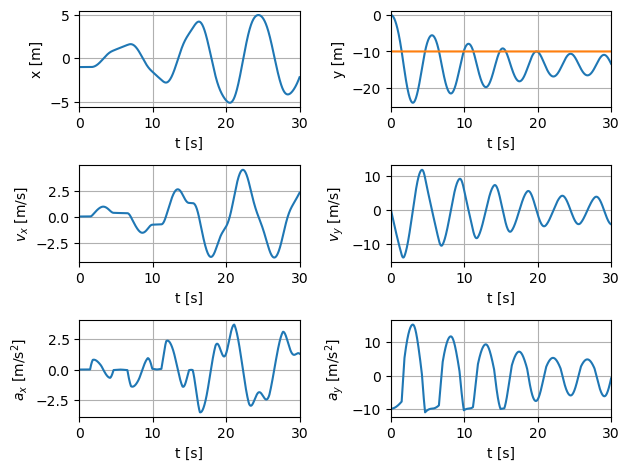

In [26]:
def draw_move_param(t, x, y, V, A, L):
    fig, ax = plt.subplots(3,2)

    for row in ax:
        for col in row:
            col.grid()
            col.set_xlabel("t [s]")
            col.set_xlim([0,np.max(t)])

    ax[0,0].plot(t,x)
    ax[0,0].set_ylabel("x [m]")

    ax[0,1].plot(t,y)
    ax[0,1].plot(t,-L*np.ones_like(y))
    ax[0,1].set_ylabel("y [m]")

    ax[1,0].plot(t,V[:,0])
    ax[1,0].set_ylabel("$v_x$ [m/s]")

    ax[1,1].plot(t,V[:,1])
    ax[1,1].set_ylabel("$v_y$ [m/s]")

    ax[2,0].plot(t,A[:,0])
    ax[2,0].set_ylabel("$a_x$ [m/s$^2$]")

    ax[2,1].plot(t,A[:,1])
    ax[2,1].set_ylabel("$a_y$ [m/s$^2$]")

    fig.tight_layout()


draw_move_param(t, x, y, V, A, L)

The following graphs will show the waveforms of the $x$ and $y$ components of the elastic forces of the rope, the resistance to movement and the resultant force acting on the jumper.

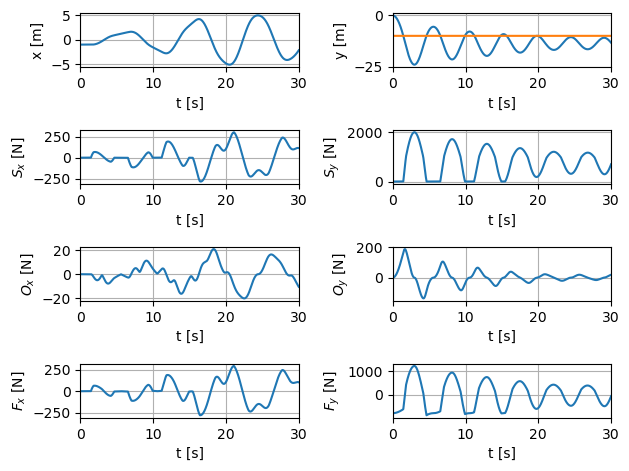

In [27]:
def draw_forces(t, x, y, S, O, F, L):
    fig, ax = plt.subplots(4,2)

    for row in ax:
        for col in row:
            col.grid()
            col.set_xlabel("t [s]")
            col.set_xlim([0,np.max(t)])

    ax[0,0].plot(t,x)
    ax[0,0].set_ylabel("x [m]")

    ax[0,1].plot(t,y)
    ax[0,1].plot(t,-L*np.ones_like(y))
    ax[0,1].set_ylabel("y [m]")

    ax[1,0].plot(t,S[:,0])
    ax[1,0].set_ylabel("$S_x$ [N]")

    ax[1,1].plot(t,S[:,1])
    ax[1,1].set_ylabel("$S_y$ [N]")

    ax[2,0].plot(t,O[:,0])
    ax[2,0].set_ylabel("$O_x$ [N]")

    ax[2,1].plot(t,O[:,1])
    ax[2,1].set_ylabel("$O_y$ [N]")

    ax[3,0].plot(t,F[:,0])
    ax[3,0].set_ylabel("$F_x$ [N]")

    ax[3,1].plot(t,F[:,1])
    ax[3,1].set_ylabel("$F_y$ [N]")

    fig.tight_layout()


draw_forces(t, x, y, S, O, F, L)

Finally, I will draw graphs showing the time course of the $y$ coordinate of the jumper, and the values of the various components of mechanical energy, i.e. his potential energy (gravity) and the elastic potential energy of the rope. In addition, I will also draw the time course of the value of the total mechanical energy of the jumper-rope system. 

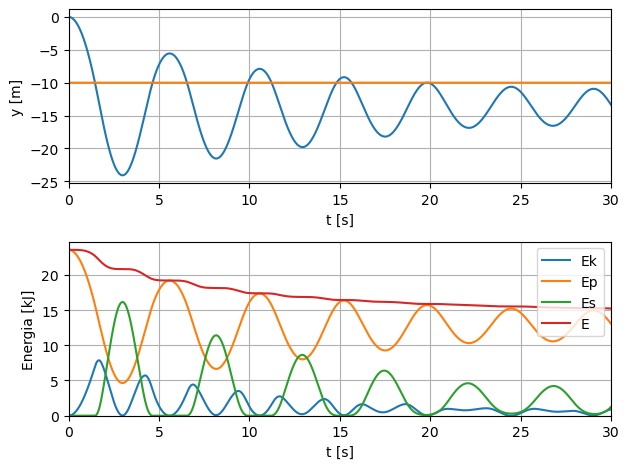

In [28]:
def draw_energy(t,x,y,Ek,Ep,Es,E,L):
    fig, ax = plt.subplots(2,1)

    for row in ax:
        row.grid()
        row.set_xlabel("t [s]")
        row.set_xlim([0,np.max(t)])

    ax[0].plot(t,y)
    ax[0].plot(t,-L*np.ones_like(y))
    ax[0].set_ylabel("y [m]")

    ax[1].plot(t,Ek/1e3)
    ax[1].plot(t,Ep/1e3)
    ax[1].plot(t,Es/1e3)
    ax[1].plot(t,E/1e3)
    ax[1].set_ylim(bottom=0)
    ax[1].set_ylabel("Energia [kJ]")
    ax[1].legend(["Ek","Ep","Es","E"], loc="upper right")

    fig.tight_layout()


draw_energy(t,x,y,Ek,Ep,Es,E,L)

## APPENDIX. Permissible parameter values

Below are the parameters that can be changed in the script data to see how the simulation results will change.

$H \in [20;50] \ \textrm{m}$

$m \in [50;150] \ \textrm{kg}$

$L \in [6;20] \ \textrm{m}$

$x_s \in [0;-L] \ \textrm{m}$

Parameters of bungee cord:
* rigid: $k_1 = 250 \ \textrm{N}/\textrm{m}$, $k_2 = 150 \ \textrm{N}/\textrm{m}$,
* average: $k_1 = 200 \ \textrm{N}/\textrm{m}$, $k_2 = 110 \ \textrm{N}/\textrm{m}$, 
* susceptible: $k_1 = 160  \ \textrm{N}/\textrm{m}$, $k_2 = 80 \ \textrm{N}/\textrm{m}$, 
* $e_b \in [4;6] \ \textrm{m}$.

Motion resistance parameters:
* $\rho \in [1.1;1.3] \ \dfrac{\textrm{kg}}{\textrm{m}^3}$,
* $C = $0.7$ for a feet-down jump and $C = $1.0$ for a flat jump,
* $A \in [0.65;1.05] \ \textrm{m}^2$, where the average overhang for a woman is $0.8$ and for a man $0.95$.

Maximum strength in bungee lines $S_{max} \approx 20 \ \textrm{kN}$

Elongation ratio to initial length $\dfrac{e}{L} \in [2;4]$